# Preparação dos Dados

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

É possível preparar um dataset somente para treino e um para teste, eu optei por utilizar somente um, e fazer a divisão via código

In [ ]:
caminho_arquivo = '/content/drive/MyDrive/TCC - UFMS/Treinamento do Modelo de Classificação de Sentimentos/Dados de Treinamento/anotacoes.csv'
df = pd.read_csv(caminho_arquivo)

Aqui eu vejo o balanceamento das classes, e vejo se será necessário aplicar alguma forma de balanceamento para não favorecer classes majoritárias

In [ ]:
sentimento_counts = df['Sentimento'].value_counts()
print(sentimento_counts)

Sentimento
Negativo    1550
Positivo    1498
Neutro       949
Neuto          1
Name: count, dtype: int64


Corrigindo erro de digitação

In [ ]:
df['Sentimento'] = df['Sentimento'].replace('Neuto', 'Neutro')

Separo as frases e os rótulos

In [ ]:
X = df['Frase'].values  # Frases
y = df['Sentimento'].values  # Rótulos

In [ ]:
from sklearn.preprocessing import LabelEncoder

Converter rótulos categóricos em valores numéricos

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentimento'])

Aqui eu vejo como ficou o mapeamento dos rótulos (Essa informação será necessária posteriormente)

In [ ]:
classes_mapeadas = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(classes_mapeadas)

{'Negativo': 0, 'Neutro': 1, 'Positivo': 2}


In [ ]:
from imblearn.over_sampling import RandomOverSampler

Como percebi um desbalanceamento das classes, utilizei uma função para balancear. Quando você tem menos exemplos de uma classe em particular, o RandomOverSampler aumenta o número de amostras da classe minoritária, criando cópias de amostras para equilibrar as classes. Isso melhora o desempenho do modelo

In [ ]:
def balance_classes(X, y):
    ros = RandomOverSampler(random_state=42)
    X, y = ros.fit_resample(X.reshape(-1, 1), y)
    return X.flatten(), y

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

A classe TextDataset é um dataset customizado do PyTorch para lidar com textos e suas labels. Cada instância do dataset realiza o seguinte:

__init__: Inicializa os textos, as labels e o tokenizer (BERTimbau). Também define o tamanho máximo de sequência (max_length), que limita o número de tokens por texto.

__len__: Retorna o número de exemplos no dataset (o comprimento da lista de textos).

__getitem__: Este método é chamado para acessar um exemplo específico (ou seja, um texto e seu rótulo) a partir de um índice. Nele:

* O texto é tokenizado usando tokenizer.encode_plus, que converte o texto em tokens (números inteiros representando palavras).
* Adiciona tokens especiais para indicar início/fim do texto.
* Limita o tamanho dos tokens ao max_length e aplica o preenchimento (padding='max_length').

**Retorna as seguintes informações:**
* input_ids: os IDs dos tokens
* attention_mask: uma máscara que indica quais tokens são reais (1) ou apenas preenchimento (0)
* labels: o rótulo da classe (convertido para tensor torch.long para compatibilidade com o PyTorch)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Treinamento

Essa função realiza o processo de treinamento de um modelo de aprendizado profundo, ela utiliza um otimizador para ajustar os parâmetros do modelo a cada mini-batch de dados (É a união do classico gradiente descendente e o estocástico, unindo precisão e eficiencia)


**Mini Batch**: Com mini-batch, o modelo ajusta os pesos mais frequentemente (após cada pequeno lote de amostras), o que permite encontrar um ótimo mais rápido do que se utilizasse todos os dados de uma vez (Gradiente Descendente). Além disso, isso reduz a variabilidade em relação ao uso de apenas uma amostra (Gradiente Estocástico).

Passos:
1. model = model.train(): Coloca o modelo em modo de treinamento. Isso é importante porque em alguns modelos (como transformers), o comportamento de certas camadas muda dependendo se o modelo está em modo de treinamento ou avaliação.

2. total_loss = 0: Inicializa a variável total_loss para acumular a perda (loss) ao longo de todos os batches.

3. Iteração sobre os batches do data_loader:
* O data_loader fornece lotes de exemplos (mini-batches) de dados, que incluem input_ids, attention_mask, e labels.

4. optimizer.zero_grad(): Zera os gradientes acumulados no otimizador a cada batch. Isso é necessário porque os gradientes no PyTorch são acumulados, então você precisa resetá-los a cada passo de otimização para evitar que os gradientes anteriores influenciem as atualizações do próximo batch.

5. Mover dados para o dispositivo (GPU ou CPU):
* input_ids, attention_mask, e labels são movidos para o dispositivo (geralmente uma GPU, se disponível) com .to(device). Isso garante que os dados estejam no mesmo dispositivo que o modelo, necessário para o cálculo eficiente.

6. Forward pass:
* outputs = model(...): O modelo faz a previsão passando os input_ids e attention_mask como entrada. O modelo também recebe os labels, o que permite calcular a perda diretamente dentro do modelo.
* O retorno outputs inclui a perda (loss), uma vez que os labels foram fornecidos.

7. Cálculo da perda:
* loss = outputs.loss: A perda é extraída dos resultados do modelo.
* total_loss += loss.item(): A perda do batch atual é somada ao total_loss para obter o valor acumulado.

8. Backward pass e atualização dos pesos:
* loss.backward(): O PyTorch calcula os gradientes dos parâmetros do modelo em relação à perda usando backpropagation.
* optimizer.step(): O otimizador ajusta os pesos do modelo com base nos gradientes calculados.

9. Retornar a perda média:
* return total_loss / len(data_loader): Após o loop sobre todos os batches, a função retorna a perda média (somatório da perda de todos os batches dividido pelo número total de batches). Isso fornece uma métrica da performance do modelo durante o treinamento.

In [ ]:
# treinamento
def train_model(model, data_loader, optimizer):
    model = model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)

# Avaliação

Essa função avalia o desempenho do modelo em um conjunto de dados de teste ou validação. Ela calcula as métricas principais de classificação, como accuracy, precision, recall e F1-score

Passos:
1. model = model.eval(): Coloca o modelo em modo de avaliação. Isso desativa certas camadas que se comportam de maneira diferente no treinamento, para garantir que o modelo funcione corretamente na fase de inferência (sem ajuste dos pesos)

2. Inicializa variáveis:
* total_correct = 0: Contador para rastrear quantas previsões corretas o modelo fez.
* total_samples = 0: Contador para o número total de amostras processadas.
* all_preds = [] e all_labels = []: Listas para armazenar todas as previsões do modelo e os rótulos verdadeiros, que serão usadas para calcular métricas globais ao final.

3. with torch.no_grad(): Bloqueia o cálculo de gradientes durante a avaliação. Isso economiza memória e melhora a eficiência, uma vez que durante a avaliação não precisamos ajustar os pesos do modelo.

4. Iteração sobre os batches do data_loader:
* Para cada batch, os dados de entrada (textos e rótulos) são movidos para o dispositivo adequado (CPU ou GPU) com .to(device).

5. Forward pass:
* outputs = model(...): O modelo faz previsões para o batch atual. Como estamos no modo de avaliação, os rótulos (labels) não são passados, e o modelo retorna apenas os logits (pontuações brutas de cada classe).
* logits = outputs.logits: Extraímos os logits, que são as saídas antes de serem convertidas em probabilidades.
* _, preds = torch.max(logits, dim=1): Aqui, usamos torch.max para obter o índice da classe com a maior pontuação (logit) em cada exemplo, o que corresponde à previsão do modelo para aquele exemplo.

6. Atualizar contadores de previsões corretas:
* total_correct += torch.sum(preds == labels): Comparamos as previsões (preds) com os rótulos verdadeiros (labels) e somamos o número de previsões corretas.
* total_samples += labels.size(0): Atualizamos o número total de amostras processadas.

7. Armazenar previsões e rótulos:
* all_preds.extend(preds.cpu().numpy()): Convertemos as previsões para o formato NumPy (usando .cpu() para mover os dados para a CPU, se estiverem na GPU) e adicionamos à lista all_preds.
* all_labels.extend(labels.cpu().numpy()): Fazemos o mesmo com os rótulos verdadeiros.

8. Cálculo das métricas:
* accuracy = accuracy_score(all_labels, all_preds): Calcula a acurácia (proporção de previsões corretas) comparando as listas de rótulos verdadeiros (all_labels) e previsões (all_preds).
* precision = precision_score(all_labels, all_preds, average='weighted'): Calcula a precisão ponderada, levando em consideração o desbalanceamento de classes.
* recall = recall_score(all_labels, all_preds, average='weighted'): Calcula o recall ponderado, que mede a proporção de exemplos corretos para cada classe.
* f1 = f1_score(all_labels, all_preds, average='weighted'): Calcula o F1-score ponderado, que é a média harmônica entre precisão e recall.

9. Retorno das métricas:
* return accuracy, precision, recall, f1: A função retorna as quatro métricas de avaliação: acurácia, precisão, recall e F1-score.

In [ ]:
# avaliação
def evaluate_model(model, data_loader):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == labels)
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1


Carregando tokenizer e modelo Bertimbau
Tokenizer: é responsável por converter texto em uma sequência de tokens que podem ser processados pelo modelo

num_labels = 3: São 3 rótulos possíveis (Positivo, Negativo e Neutro)

o modelo realiza:

* Embedding: Cada token de entrada (gerado pelo tokenizador) é mapeado para uma representação vetorial.
* Camadas Transformer: O modelo BERT possui várias camadas transformer que processam a sequência de tokens e capturam as dependências contextuais entre as palavras.
* Classificação: No final, o token [CLS] contém uma representação que é passada por uma camada densa para gerar as probabilidades de cada uma das três classes.

torch.device("cuda" if torch.cuda.is_available() else "cpu"): O código verifica se uma GPU (CUDA) está disponível. Se estiver, o modelo será movido para a GPU, o que acelera bastante. Caso contrário, o modelo será executado na CPU.
model.to(device): Move o modelo para o dispositivo apropriado (GPU ou CPU). Todos os cálculos subsequentes ocorrerão nesse dispositivo.

In [ ]:
# tokenizer e o modelo BERTimbau
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validação Cruzada Estratificada


Validação Cruzada: É uma técnica usada para avaliar o desempenho de um modelo, dividindo os dados em várias "partições" (folds). No K-fold tradicional, o conjunto de dados é dividido em n_splits subconjuntos (ou folds). Em cada iteração, o modelo é treinado em n_splits-1 folds e testado no fold restante. Isso é repetido n_splits vezes, de modo que cada fold seja usado uma vez como teste. A média dos resultados é calculada para fornecer uma estimativa robusta da performance do modelo.

Estratificação: No caso da validação cruzada estratificada, a divisão dos dados em cada fold é feita de maneira que as proporções das classes no conjunto de treino e no conjunto de validação sejam as mesmas (ou o mais próximo possível) daquelas no conjunto de dados original.

In [ ]:
# Definir o número de folds para validação cruzada
n_splits = 30 #10 é o mais comum, mas pode aumentar o número de folds desde que contenha no minimo 30 exemplos em cada fold, ex: 100 exemplos anotados, deve ter no maximo 3 folds / Deve-se saber tbm, que quanto maior o número de folds, maior o custo computacional
skf = StratifiedKFold(n_splits=n_splits)

Otimizador

* O AdamW é uma variante do otimizador Adam, projetada para melhorar a regularização do modelo ao aplicar a decadência do peso (weight decay). A decadência do peso é uma técnica de regularização que evita que os pesos do modelo se tornem excessivamente grandes, o que pode levar ao overfitting.

* lr=1e-5: Define a taxa de aprendizado (learning rate) como 0.00001. Esse valor é pequeno porque o BERT já é um modelo pré-treinado, e o fine-tuning geralmente requer uma taxa de aprendizado baixa para evitar que os pesos sejam drasticamente ajustados. O fine-tuning ajusta o modelo para a tarefa específica sem destruir o conhecimento previamente aprendido.

In [ ]:
# Otimizador
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Dicionário para Armazenar Métricas de Avaliação por Fold

In [ ]:
all_fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Treinamento e Avaliação de Modelo com Validação Cruzada Estratificada e Balanceamento de Classes

In [ ]:
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}/{n_splits}")

    # Dividir os dados em treino e teste
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Balancear as classes no conjunto de treino
    X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)

    # Criar datasets e dataloaders
    train_dataset = TextDataset(X_train_balanced, y_train_balanced, tokenizer)
    test_dataset = TextDataset(X_test, y_test, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # mini-batch de tamanho 16 e shuffle para pegar amostras aleatórias
    test_loader = DataLoader(test_dataset, batch_size=16) # mini-batch de tamanho 16

    # Treinar o modelo no fold atual
    train_loss = train_model(model, train_loader, optimizer)
    print(f"Loss de treino no Fold {fold+1}: {train_loss}") #quanto menor a loss em cada fold significa que o modelo está aprendendo

    # Avaliar o modelo no fold atual
    accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
    #print(f"Acurácia no Fold {fold+1}: {accuracy}")
    #print(f"Precisão no Fold {fold+1}: {precision}")
    #print(f"Recall no Fold {fold+1}: {recall}")
    #print(f"F1-score no Fold {fold+1}: {f1}")

    # Armazenar métricas para cada fold
    all_fold_metrics['accuracy'].append(accuracy)
    all_fold_metrics['precision'].append(precision)
    all_fold_metrics['recall'].append(recall)
    all_fold_metrics['f1'].append(f1)

# Cálculo das métricas finais (médias)
final_accuracy = np.mean(all_fold_metrics['accuracy'])
final_precision = np.mean(all_fold_metrics['precision'])
final_recall = np.mean(all_fold_metrics['recall'])
final_f1 = np.mean(all_fold_metrics['f1'])

print(f"\nDesempenho Final:")
print(f"Accuracy Média: {final_accuracy}")
print(f"Precision Média: {final_precision}")
print(f"Recall Médio: {final_recall}")
print(f"F1-score Médio: {final_f1}")

Fold 1/30
Loss de treino no Fold 1: 0.7241429907677437
Fold 2/30
Loss de treino no Fold 2: 0.44425444819324805
Fold 3/30
Loss de treino no Fold 3: 0.3482575904299568
Fold 4/30
Loss de treino no Fold 4: 0.276575132077593
Fold 5/30
Loss de treino no Fold 5: 0.22720992720927843
Fold 6/30
Loss de treino no Fold 6: 0.18217339269233557
Fold 7/30
Loss de treino no Fold 7: 0.1463369479489072
Fold 8/30
Loss de treino no Fold 8: 0.13318660046268932
Fold 9/30
Loss de treino no Fold 9: 0.10798183650779289
Fold 10/30
Loss de treino no Fold 10: 0.08447092279685774
Fold 11/30
Loss de treino no Fold 11: 0.06516691241446498
Fold 12/30
Loss de treino no Fold 12: 0.06587406282240253
Fold 13/30
Loss de treino no Fold 13: 0.052666780615086235
Fold 14/30
Loss de treino no Fold 14: 0.04270540477394779
Fold 15/30
Loss de treino no Fold 15: 0.03974276542202884
Fold 16/30
Loss de treino no Fold 16: 0.03733855531073683
Fold 17/30
Loss de treino no Fold 17: 0.03828405845724709
Fold 18/30
Loss de treino no Fold 18

Baixar modelo para uso posterior

In [ ]:
!mkdir model
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")

!zip -r /content/model.zip /content/model

from google.colab import files
files.download("/content/model.zip")

  adding: content/model/ (stored 0%)
  adding: content/model/special_tokens_map.json (deflated 42%)
  adding: content/model/config.json (deflated 55%)
  adding: content/model/model.safetensors (deflated 7%)
  adding: content/model/tokenizer_config.json (deflated 75%)
  adding: content/model/vocab.txt (deflated 52%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Utilizando o Modelo para o Feminino

In [ ]:
caminho_arquivo1 = '/content/drive/MyDrive/TCC - UFMS/Treinamento do Modelo de Classificação de Sentimentos/df sem duplicatas.csv'
df1 = pd.read_csv(caminho_arquivo1)

In [ ]:
df1.head()

,Padrão,Frase,Nome da Música,Artista,Gênero Musical,Letra da Música
0,sujeito_aux_adv_adj,ela é muito sensual,Carolina,Seu Jorge,MPB,Carolina é uma menina bem difícil de esquecer ...
1,sujeito_adj,menina bela,Carolina,Seu Jorge,MPB,Carolina é uma menina bem difícil de esquecer ...
2,pronoun+aux+adj,você é diferente,Tarde Vazia (feat. Samuel Rosa) - Versão Acústica,Ira!,Rock,"Pela janela vejo fumaça, vejo pessoas Na rua o..."
3,sujeito_aux_adj,ela é linda,Rodo cotidiano,O Rappa,Rock,Ô ô ô ô ô my brother Ô ô ô ô ô my brother Ô ô ...
4,sujeito_aux_adj,ela é guerreira,Ela Vai Voltar (Todos Os Defeitos De Uma Mulhe...,Charlie Brown Jr.,Rock,"Minha mente, nem sempre tão lúcida É fértil e ..."


In [ ]:
df1.shape

(15223, 6)

In [ ]:
sentencas = df1['Frase'].tolist()

In [ ]:
batch_size = 16
predicoes_finais = []
model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# mini batch
for i in range(0, len(sentencas), batch_size):
    sentencas_lote = sentencas[i:i+batch_size]

    tokens = tokenizer(
        sentencas_lote,
        padding=True,
        truncation=True,
        max_length=128,  # Mesmo max_length usado no treino
        return_tensors="pt"
    )

    tokens = {key: val.to(device) for key, val in tokens.items()}

    with torch.no_grad():
        outputs = model(**tokens)

    # Obter as previsões (softmax -> argmax para pegar a classe mais provável)
    pred_classes = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Mover para a CPU pq tava dando estouro de GPU

    predicoes_finais.extend(pred_classes)

In [ ]:
df1['Sentimento'] = predicoes_finais

df1['Sentimento'] = df1['Sentimento'].map({0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}) #{'Negativo': 0, 'Neutro': 1, 'Positivo': 2}

In [ ]:
from google.colab import files

df1.to_csv('df1_com_previsoes.csv', index=False)
files.download('df1_com_previsoes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentimento_counts_df1 = df1['Sentimento'].value_counts()
print(sentimento_counts_df1)

Sentimento
Positivo    6169
Neutro      4617
Negativo    4437
Name: count, dtype: int64


# Utilizando o Modelo para o Masculino

In [ ]:
caminho_arquivo2 = '/content/drive/MyDrive/TCC - UFMS/Treinamento do Modelo de Classificação de Sentimentos/df masculino sem duplicata.csv'
df2 = pd.read_csv(caminho_arquivo2)

In [ ]:
df2.head()

,Padrão,Frase,Nome da Música,Artista,Gênero Musical,Letra da Música
0,nome_NOUN,caro pai,Lugar Ao Sol,Charlie Brown Jr.,Rock,"Que bom viver, como é bom sonhar E o que ficou..."
1,pronoun_aposto_adjetivo_noun_det,"você, o mar","Eu, Você, O Mar e Ela",Luan Santana,Sertanejo,Ser romântico às vezes ajuda Mas se fecho os o...
2,nome_aux_NOUN,cês são padre,Balão,Orochi,Trap,"Dallass, yo Bom dia pra você e pra todos que e..."
3,nome_NOUN,meto marcha,Deus é por nós,MC Marks,Funk,"(Ai, ai, ai, ai, ai) (Ai, ai, ai, ai, ai) (É o..."
4,sujeito_NOUN,namorado ficar,Meu Pedaço de Pecado,João Gomes,Forró,Meu pedaço de pecado De corpo colado Vem dança...


In [ ]:
df2.shape

(15081, 6)

In [ ]:
sentencasMasc = df2['Frase'].tolist()

In [ ]:
batch_size = 16

predicoes_finais2 = []

model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# mini batch
for i in range(0, len(sentencasMasc), batch_size):
    sentencas2_lote = sentencasMasc[i:i+batch_size]

    tokens = tokenizer(
        sentencas2_lote,
        padding=True,
        truncation=True,
        max_length=128,  # Mesmo max_length usado no treino
        return_tensors="pt"
    )

    tokens = {key: val.to(device) for key, val in tokens.items()}

    with torch.no_grad():
        outputs2 = model(**tokens)

    # Obter as previsões (softmax -> argmax para pegar a classe mais provável)
    pred_classes2 = torch.argmax(outputs2.logits, dim=1).cpu().numpy()  # Mover para a CPU pq tava dando estouro de GPU

    predicoes_finais2.extend(pred_classes2)

In [ ]:
df2['Sentimento'] = predicoes_finais2

df2['Sentimento'] = df2['Sentimento'].map({0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}) #{'Negativo': 0, 'Neutro': 1, 'Positivo': 2}

In [ ]:
from google.colab import files

df2.to_csv('df2_com_previsoes.csv', index=False)
files.download('df2_com_previsoes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentimento_counts_df2 = df2['Sentimento'].value_counts()
print(sentimento_counts_df2)

Sentimento
Neutro      5878
Positivo    5370
Negativo    3833
Name: count, dtype: int64


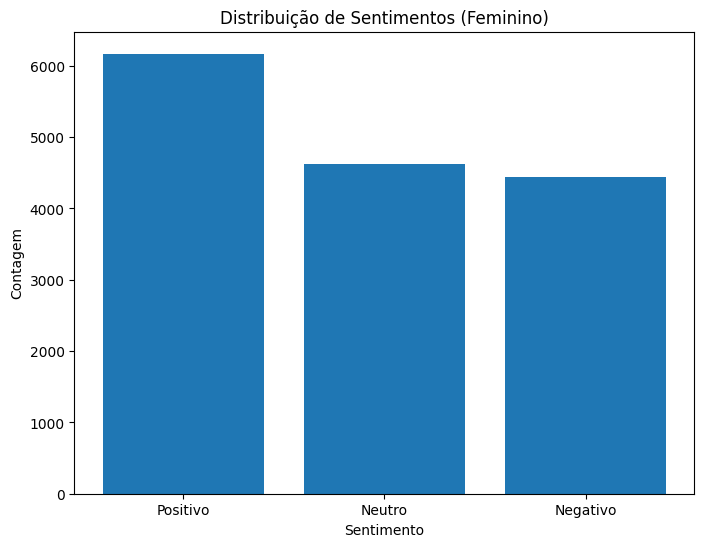

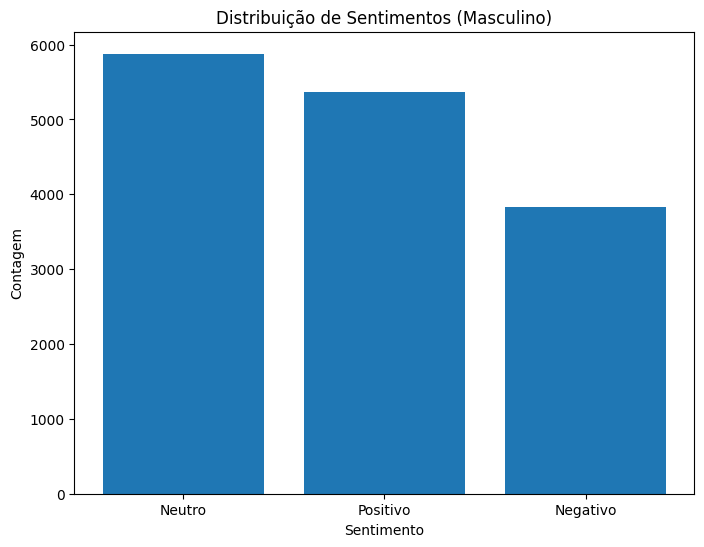

In [ ]:
import matplotlib.pyplot as plt

# Gráfico para df1
plt.figure(figsize=(8, 6))
plt.bar(sentimento_counts_df1.index, sentimento_counts_df1.values)
plt.title('Distribuição de Sentimentos (Feminino)')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.show()

# Gráfico para df2
plt.figure(figsize=(8, 6))
plt.bar(sentimento_counts_df2.index, sentimento_counts_df2.values)
plt.title('Distribuição de Sentimentos (Masculino)')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.show()
